<a href="https://colab.research.google.com/github/AbouCamara/IA-FORCE-N/blob/main/Syst%C3%A8me_de_Classification_d'images_de_cultures_agricoles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# iImporter les bibliothèques nécessaires

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
# Chemin d'accès aux images

# Chemin vers votre dossier dans Google Drive
drive_path = '/content/drive/MyDrive/Agricultural-crops'

# Vérifier le contenu du dossier
!ls "{drive_path}"

 almond     coconut	        jowar	      papaya		     sunflower
 banana     Coffee-plant        jute	     'Pearl_millet(bajra)'   tea
 cardamom   cotton	        Lemon	      pineapple		     Tobacco-plant
 Cherry     Cucumber	        maize	      rice		     tomato
 chilli    'Fox_nut(Makhana)'   mustard-oil   soyabean		    'vigna-radiati(Mung)'
 clove	    gram	        Olive-tree    sugarcane		     wheat


In [ ]:
# Fonction de chargement des images

def load_images_from_drive(folder_path, img_size=(128, 128), max_images=None):
    """
    Charge les images depuis Google Drive
    Args:
        folder_path (str): Chemin relatif dans Google Drive
        img_size (tuple): Taille de redimensionnement
        max_images (int): Nombre max d'images à charger (None = toutes)
    Returns:
        tuple: (images, labels, class_names)
    """
    full_path = os.path.join(drive_path, folder_path)
    class_names = sorted([d for d in os.listdir(full_path) if os.path.isdir(os.path.join(full_path, d))])

    images = []
    labels = []

    for label, class_name in enumerate(class_names):
        class_dir = os.path.join(full_path, class_name)
        files = [f for f in os.listdir(class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        if max_images:
            files = files[:max_images]

        print(f"Chargement {len(files)} images de la classe {class_name}...")

        for file in tqdm(files):
            try:
                img_path = os.path.join(class_dir, file)
                img = cv2.imread(img_path)

                if img is None:
                    continue

                # Conversion BGR vers RGB + redimensionnement
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, img_size)
                img = img.astype(np.float32) / 255.0  # Normalisation

                images.append(img)
                labels.append(label)

            except Exception as e:
                print(f"Erreur avec {file}: {str(e)}")

    return np.array(images), np.array(labels), class_names

Chargement 32 images de la classe Cherry...


100%|██████████| 32/32 [00:19<00:00,  1.62it/s]


Chargement 29 images de la classe Coffee-plant...


100%|██████████| 29/29 [00:16<00:00,  1.75it/s]


Chargement 31 images de la classe Cucumber...


100%|██████████| 31/31 [00:30<00:00,  1.01it/s]


Chargement 23 images de la classe Fox_nut(Makhana)...


100%|██████████| 23/23 [00:12<00:00,  1.89it/s]


Chargement 28 images de la classe Lemon...


100%|██████████| 28/28 [00:14<00:00,  2.00it/s]


Chargement 30 images de la classe Olive-tree...


100%|██████████| 30/30 [00:22<00:00,  1.36it/s]


Chargement 39 images de la classe Pearl_millet(bajra)...


100%|██████████| 39/39 [00:23<00:00,  1.64it/s]


Chargement 33 images de la classe Tobacco-plant...


100%|██████████| 33/33 [00:16<00:00,  2.01it/s]


Chargement 21 images de la classe almond...


100%|██████████| 21/21 [00:17<00:00,  1.22it/s]


Chargement 31 images de la classe banana...


100%|██████████| 31/31 [00:31<00:00,  1.00s/it]


Chargement 22 images de la classe cardamom...


100%|██████████| 22/22 [00:13<00:00,  1.62it/s]


Chargement 23 images de la classe chilli...


100%|██████████| 23/23 [00:11<00:00,  2.03it/s]


Chargement 30 images de la classe clove...


100%|██████████| 30/30 [00:16<00:00,  1.84it/s]


Chargement 25 images de la classe coconut...


100%|██████████| 25/25 [00:24<00:00,  1.02it/s]


Chargement 32 images de la classe cotton...


100%|██████████| 32/32 [00:27<00:00,  1.18it/s]


Chargement 25 images de la classe gram...


100%|██████████| 25/25 [00:18<00:00,  1.32it/s]


Chargement 30 images de la classe jowar...


100%|██████████| 30/30 [00:24<00:00,  1.21it/s]


Chargement 23 images de la classe jute...


100%|██████████| 23/23 [00:19<00:00,  1.16it/s]


Chargement 31 images de la classe maize...


100%|██████████| 31/31 [00:23<00:00,  1.30it/s]


Chargement 28 images de la classe mustard-oil...


100%|██████████| 28/28 [00:19<00:00,  1.42it/s]


Chargement 23 images de la classe papaya...


100%|██████████| 23/23 [00:23<00:00,  1.03s/it]


Chargement 25 images de la classe pineapple...


100%|██████████| 25/25 [00:13<00:00,  1.82it/s]


Chargement 29 images de la classe rice...


100%|██████████| 29/29 [00:20<00:00,  1.42it/s]


Chargement 30 images de la classe soyabean...


100%|██████████| 30/30 [00:19<00:00,  1.58it/s]


Chargement 25 images de la classe sugarcane...


100%|██████████| 25/25 [00:17<00:00,  1.42it/s]


Chargement 24 images de la classe sunflower...


100%|██████████| 24/24 [00:21<00:00,  1.11it/s]


Chargement 23 images de la classe tea...


100%|██████████| 23/23 [00:13<00:00,  1.71it/s]


Chargement 26 images de la classe tomato...


100%|██████████| 26/26 [00:15<00:00,  1.66it/s]


Chargement 27 images de la classe vigna-radiati(Mung)...


100%|██████████| 27/27 [00:15<00:00,  1.70it/s]


Chargement 31 images de la classe wheat...


100%|██████████| 31/31 [00:25<00:00,  1.23it/s]



Dimensions des données : (829, 128, 128, 3)
Exemple de label : 0 (Cherry)


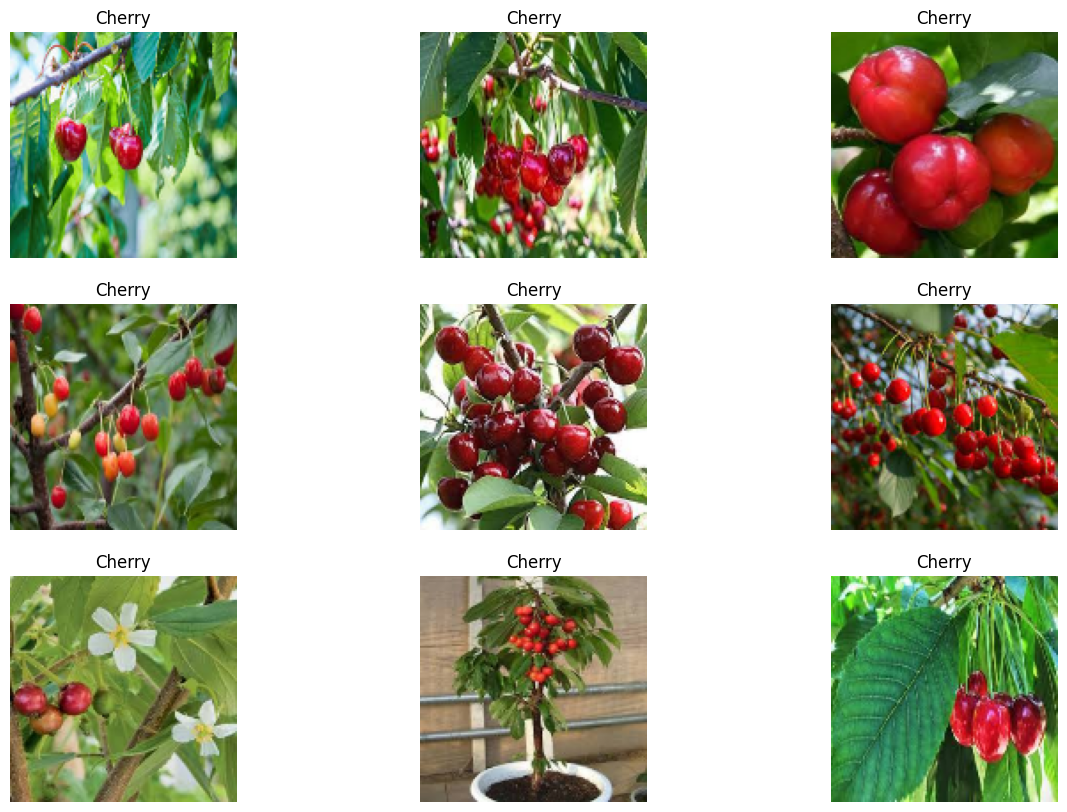

In [47]:
# Utilisation

# Exemple de chemin (à adapter)
dataset_folder = "/content/drive/MyDrive/Agricultural-crops/"  # Doit contenir des sous-dossiers par classe

# Chargement
images, labels, classes = load_images_from_drive(
    folder_path=dataset_folder,
    img_size=(128, 128),
    max_images=1000  # Limiter à 1000 images par classe
)

# Vérification
print(f"\nDimensions des données : {images.shape}")
print(f"Exemple de label : {labels[0]} ({classes[labels[0]]})")

# Visualisation
plt.figure(figsize=(15, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i])
    plt.title(classes[labels[i]])
    plt.axis('off')
plt.show()

Nombre total de classes: 30


<ipython-input-48-f4deb0353185>:38: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


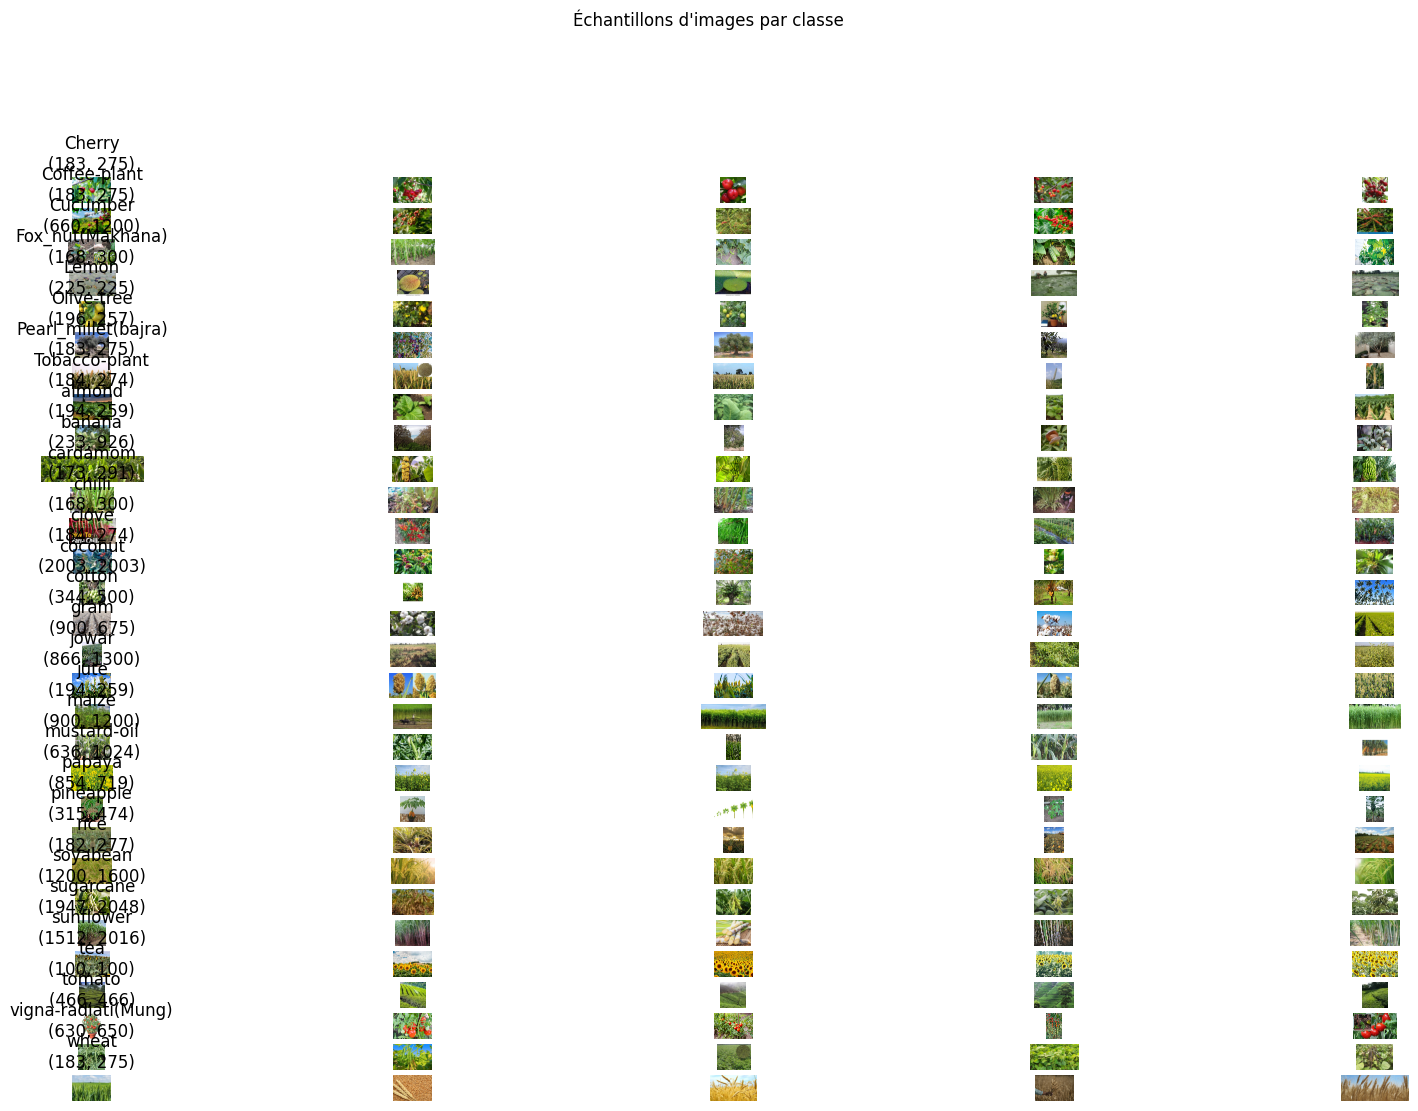

<ipython-input-48-f4deb0353185>:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(class_counts.values()), y=list(class_counts.keys()), palette="viridis")


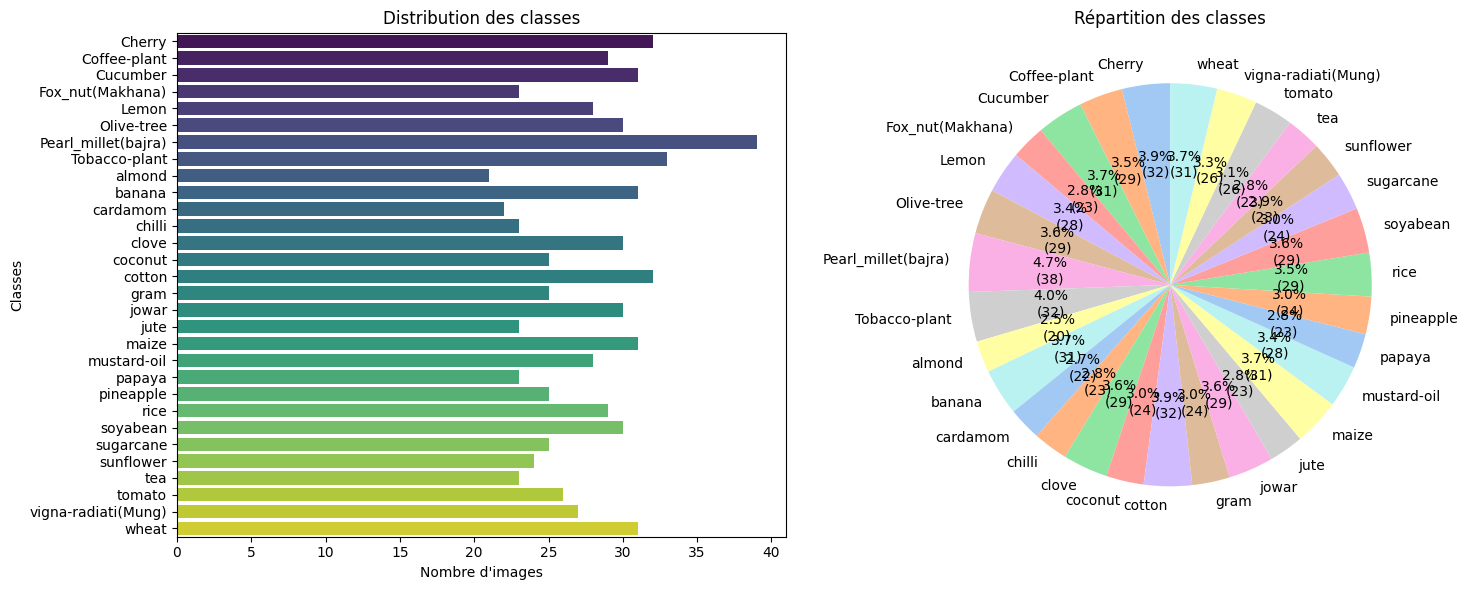


Statistiques détaillées:
Nombre total d'images: 829
Nombre moyen d'images par classe: 27.6
Écart-type: 4.1
Classe la plus fréquente: Pearl_millet(bajra) (39 images)
Classe la moins fréquente: almond (21 images)

✅ Distribution relativement équilibrée


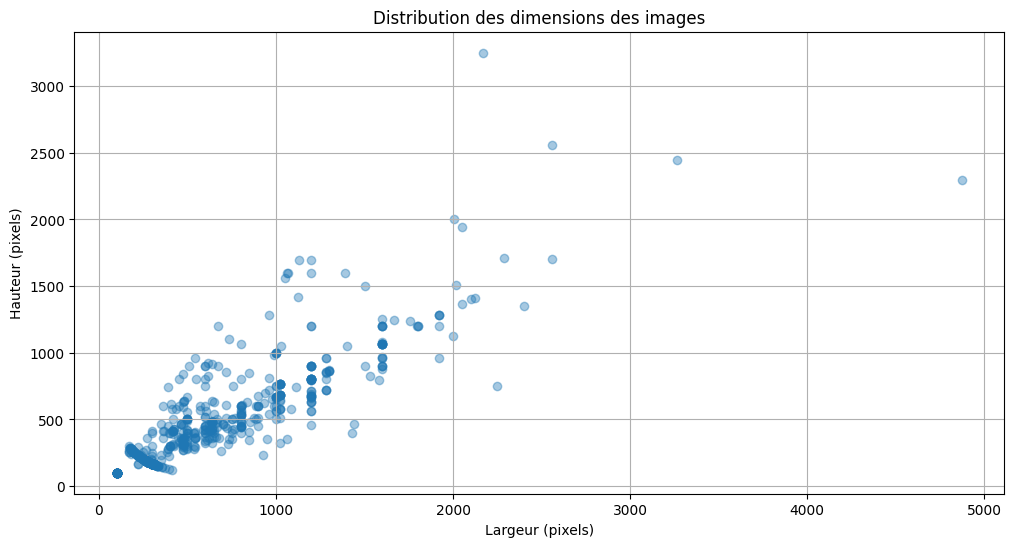

In [48]:
import seaborn as sns
from collections import defaultdict

# Configuration
DATASET_PATH = "/content/drive/MyDrive/Agricultural-crops"  # Chemin vers vos données
SAMPLE_PER_CLASS = 5            # Nombre d'échantillons à visualiser par classe

# 1. Exploration initiale du dataset
class_counts = defaultdict(int)
class_names = sorted([d for d in os.listdir(DATASET_PATH) if os.path.isdir(os.path.join(DATASET_PATH, d))])

print(f"Nombre total de classes: {len(class_names)}")

# 2. Visualisation d'échantillons d'images
plt.figure(figsize=(20, 12))
plot_index = 1

for class_idx, class_name in enumerate(class_names):
    class_dir = os.path.join(DATASET_PATH, class_name)
    images = [f for f in os.listdir(class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    class_counts[class_name] = len(images)

    # Affichage d'échantillons d'images
    for img_idx in range(SAMPLE_PER_CLASS):
        if img_idx >= len(images):
            break

        img_path = os.path.join(class_dir, images[img_idx])
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

        plt.subplot(len(class_names), SAMPLE_PER_CLASS, plot_index)
        plt.imshow(img)
        plt.title(f"{class_name}\n{img.shape[:2]}" if img_idx == 0 else "")
        plt.axis('off')
        plot_index += 1

plt.suptitle("Échantillons d'images par classe", y=1.02)
plt.tight_layout()
plt.show()

# 3. Analyse de la distribution des classes
plt.figure(figsize=(15, 6))

# Diagramme en barres
plt.subplot(1, 2, 1)
sns.barplot(x=list(class_counts.values()), y=list(class_counts.keys()), palette="viridis")
plt.title("Distribution des classes")
plt.xlabel("Nombre d'images")
plt.ylabel("Classes")

# Diagramme circulaire
plt.subplot(1, 2, 2)
plt.pie(class_counts.values(),
        labels=class_counts.keys(),
        autopct=lambda p: f'{p:.1f}%\n({int(p*sum(class_counts.values())/100)})',
        startangle=90,
        colors=sns.color_palette("pastel"))
plt.title("Répartition des classes")
plt.tight_layout()
plt.show()

# 4. Statistiques détaillées
total_images = sum(class_counts.values())
print("\nStatistiques détaillées:")
print(f"Nombre total d'images: {total_images}")
print(f"Nombre moyen d'images par classe: {np.mean(list(class_counts.values())):.1f}")
print(f"Écart-type: {np.std(list(class_counts.values())):.1f}")
print(f"Classe la plus fréquente: {max(class_counts, key=class_counts.get)} ({max(class_counts.values())} images)")
print(f"Classe la moins fréquente: {min(class_counts, key=class_counts.get)} ({min(class_counts.values())} images)")

# 5. Détection des déséquilibres
balance_threshold = 0.3  # Ratio acceptable entre plus petite et plus grande classe
max_count = max(class_counts.values())
min_count = min(class_counts.values())

if min_count/max_count < balance_threshold:
    print("\n⚠️ Alerte: Déséquilibre important détecté !")
    print(f"Ratio min/max: {min_count/max_count:.2f}")
    print("Solutions possibles:")
    print("- Data Augmentation pour les classes minoritaires")
    print("- Rééchantillonnage (oversampling/undersampling)")
    print("- Utilisation de class weights pendant l'entraînement")
else:
    print("\n✅ Distribution relativement équilibrée")

# 6. Visualisation avancée des dimensions d'images
sizes = []
for class_name in class_names:
    class_dir = os.path.join(DATASET_PATH, class_name)
    for img_file in os.listdir(class_dir)[:100]:  # Échantillonner pour gagner du temps
        img = cv2.imread(os.path.join(class_dir, img_file))
        if img is not None:
            sizes.append(img.shape[:2])

sizes = np.array(sizes)
plt.figure(figsize=(12, 6))
plt.scatter(sizes[:, 1], sizes[:, 0], alpha=0.4)  # width vs height
plt.title("Distribution des dimensions des images")
plt.xlabel("Largeur (pixels)")
plt.ylabel("Hauteur (pixels)")
plt.grid(True)
plt.show()